# Frangi's Vesselness Filter

## Summary
**Frangi Vs Similar Hessian Ridge operators**
- `Frangi` has sharper/higher contrast 
- Compared to `Sato` has clearer background; higher noise/bacground suppression


**Frangi Vs Edge operators**
Tried edge operators that use second order derivative 
- Edge operators may find some of the veins. 
- Edge operators cannot distinguish vessel from background and so do not suppress backgroun 
- Edge operators will amplify any noise in background or introduce noise even when used with smoothing. 


**Frangi Vs Morphological operators**
Tried morphological by itself and in concert with edge operators
- Binary thresholding is necessary prior to applying morphological operators. Choice of threshold may carry forward artifacts e.g. `OTSU` does better than `Mean`.
- Seems to have challenges with background noise sensitivity and creating discontinous edges - everything that we don't want.

- **TODO:** Paper that uses morphological processing

In [1]:
%run "000_includez.ipynb"

In [2]:
import skimage
import skimage.filters as skfilters

## Input Image
Source: `skimage.data` 

Type: Retina image

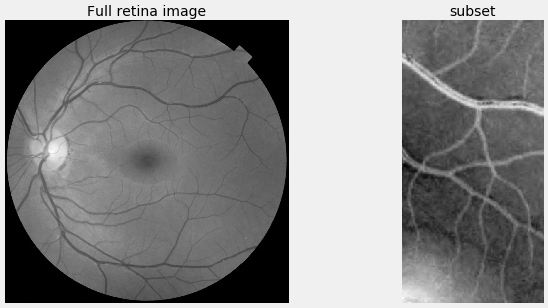

In [3]:
img_full = skimage.color.rgb2gray( skimage.data.retina() )
img = img_full[300:700, 700:900] *-1
#show_image_hist(img)
show_image_list([img_full, img], titlez=['Full retina image', 'subset'])

## Frangi's Vesselness Filter Vs Sato
**Frangi's**: Detects continuous ridges or vessels and can also be used to calculate the propotion of the image that contains vessels. 

- Uses Eigenvalyes of the Hessian to compute similarity of a pixel region to vessel 
- Parameters: `sigma` for scale 
- `skimage.filters.frangi` 


**Sato's**: Similar to Frangi but uses only some of the eigenvalues instead of all at the same time. Frangi is a generalization of Sato's. 
-  `skimage.filters.sato` 
    

With white ridges


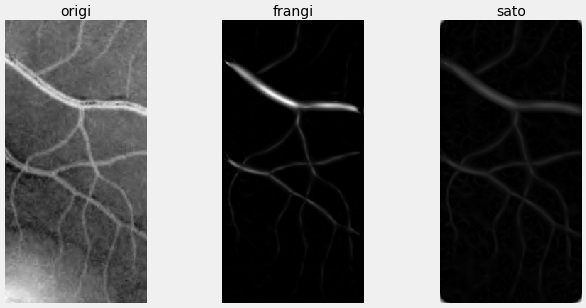

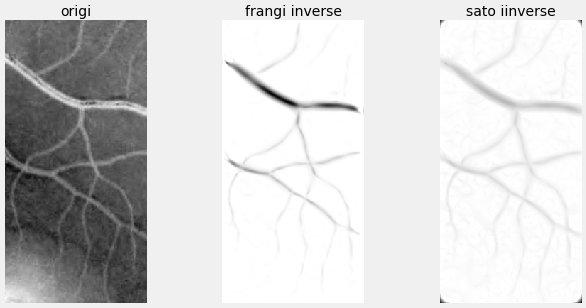

In [4]:
sigmaz = [ x/10 for x in range(4,100,2)]
paramz = {'sigmas':sigmaz, 'black_ridges':1 }

img_frangi = skimage.filters.frangi(img, **paramz)
img_sato = skimage.filters.sato(img, **paramz)

paramz = {'sigmas':sigmaz, 'black_ridges':0 }
img_frangi2 = skimage.filters.frangi(img, **paramz)
img_sato2 = skimage.filters.sato(img, **paramz)

# print('With black ridges')
# show_image_list([img_frangi, img_sato], titlez=['frangi', 'sato'])
# plt.clf()
print('With white ridges')
show_image_list([img, img_frangi2, img_sato2], titlez=['origi','frangi', 'sato'], nc=3)
plt.clf();
show_image_list([img, img_frangi2*-1, img_sato2*-1], titlez=['origi','frangi inverse', 'sato iinverse'], nc=3)
plt.show();

## Frangi's vesselness filter Vs Morphological
**Morphological:**
Operates best on binary so may be need to do something else first, say edges or something?? 

PS: Swapped `mediam` for `yen` threshold last minute b/c seems to have better binary img thresholding results. 


**Results:**
Noisy even with
- smoothing first
- smooting and edge detect first followed by morphological opening/closing or vice versa
- Small smoothing sigma has better results. 

In [29]:
def morph_vessel_enhance(img, selement, sigma=1, thresher=None, ifrangi=img_frangi2, dilate=2, erode=1):
    ## 1. smooth image and then binary threshold 
    ## 2. open Vs close
    ## 3. binary threshold with say OTSU or median 
    ## structuring element types
    smoothed = skimage.filters.gaussian(img, sigma=sigma)    
    bi_thresh = thresher(smoothed) if thresher else skimage.filters.threshold_local(smoothed)
    bi_img = smoothed > bi_thresh
#     bi_img = smoothed
    opened = skimage.morphology.opening(bi_img, selement)
    closed = skimage.morphology.closing(bi_img, selement)
    skel = skimage.morphology.skeletonize(bi_img == 0)
#     skel = opened - img
    
    show_image_list(np.array([ifrangi, opened, closed, skel])*-1,
                   titlez=['frangi', 'opened', 'closed', 'skel'], nc=4)
    
def morph_with_edge_vessel_enhance(img, selement, sigma=1, thresher=None, ifrangi=img_frangi2, dilate=2, erode=1):
    ## 1. smooth image and then binary threshold 
    ## 2. open Vs close
    ## 3. binary threshold with say OTSU or median or something 
    ## 4. edge detect with canny or sobel or scharr
    ## structuring element types
    def run_it(edger, ename):
        smoothed = skimage.filters.gaussian(img, sigma=sigma)    
        bi_thresh = thresher(smoothed) if thresher else skimage.filters.threshold_local(smoothed)
        bi_img = smoothed > bi_thresh 
        opened = skimage.morphology.opening(bi_img, selement)
        opened = edger( opened )
        closed = skimage.morphology.closing(bi_img, selement)
        closed = edger( closed )
        skel = skimage.morphology.skeletonize(bi_img == 0)

        show_image_list( np.array([ifrangi, opened, closed, skel])*-1,
                       titlez=['frangi', f'opened+{ename}', f'closed+{ename}', 'skel'], nc=4)
    
    run_it(skimage.filters.sobel, 'sobel')
    plt.clf();
    
    run_it(skimage.feature.canny, 'canny')
    plt.show();
    
def morph_with_edge1st_vessel_enhance(img, selement, sigma=1, thresher=None, ifrangi=img_frangi2, dilate=2, erode=1):
    ## 1. smooth image and then binary threshold 
    ## 2. open Vs close
    ## 3. binary threshold with say OTSU or median or something 
    ## 4. edge detect with canny or sobel or scharr
    ## structuring element types
    def run_it(edger, ename):
        smoothed = skimage.filters.gaussian(img, sigma=sigma)    
        bi_thresh = thresher(smoothed) if thresher else skimage.filters.threshold_local(smoothed)
        bi_img = smoothed > bi_thresh 
        bi_img = edger( bi_img )
        opened = skimage.morphology.opening(bi_img, selement)
        closed = skimage.morphology.closing(bi_img, selement)
        skel = skimage.morphology.skeletonize(bi_img == 0)

        show_image_list(np.array([ifrangi, opened, closed, skel])*-1,
                       titlez=['frangi', f'{ename}+opened', f'{ename}+closed', 'skel'], nc=4)
    
    run_it(skimage.filters.sobel, 'sobel')
    plt.clf();
    
    run_it(skimage.feature.canny, 'canny')
    plt.show();

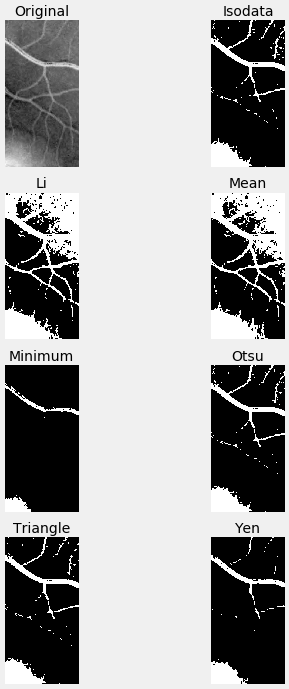

In [27]:
## Check out different thresholds
smoothed = skimage.filters.gaussian(img, sigma=1) 
fig, ax = skimage.filters.try_all_threshold(img, figsize=(20,14), verbose=False);
plt.tight_layout()
plt.show();

### Morphological by itself 
Includes smoothing and binary thresholding 
- OTSU thresholding seems better than mean

OTSU Threshold


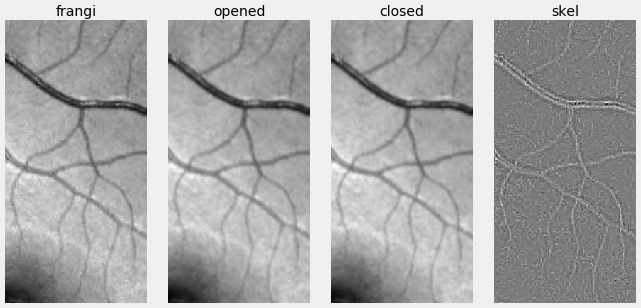

Yen Threshold


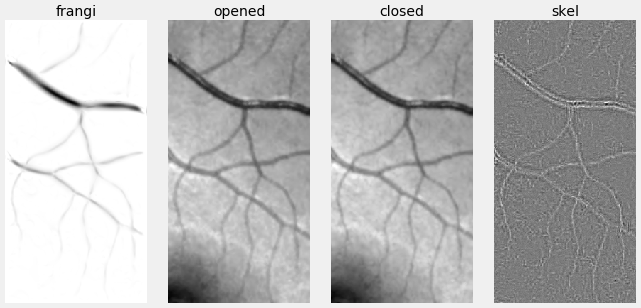

In [31]:
selement = skimage.morphology.disk(1)
print('OTSU Threshold')
morph_vessel_enhance(img, selement, #ifrangi=img,
                     thresher=skimage.filters.threshold_otsu)
plt.clf();

print('Yen Threshold')
morph_vessel_enhance(img, selement, 
                     thresher=skimage.filters.threshold_yen)
plt.show(); 

### Morphological with discrete edge detection last
Seems to be amplifying noise and discontinuity or seperation of segments

OTSU Threshold


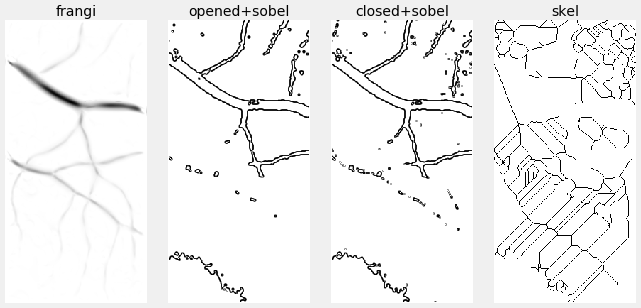

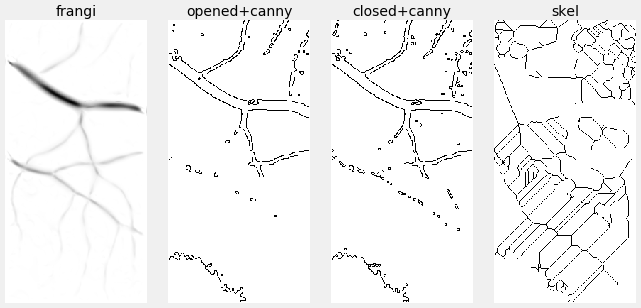

Yen Threshold


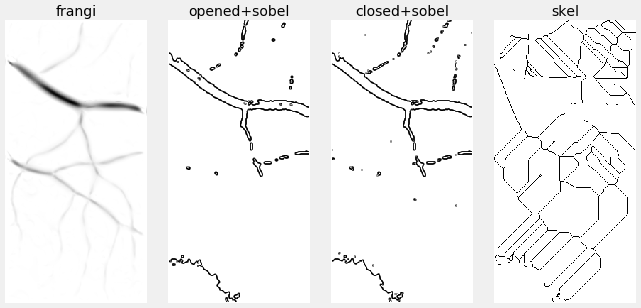

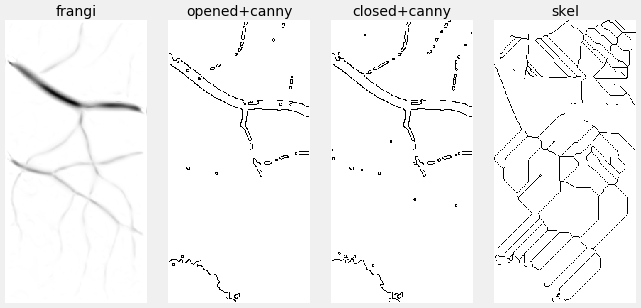

In [8]:
selement = skimage.morphology.disk(1)
print('OTSU Threshold')
morph_with_edge_vessel_enhance(img, selement, sigma=0.25,
                               thresher=skimage.filters.threshold_otsu)
plt.clf();

print('Yen Threshold')
morph_with_edge_vessel_enhance(img, selement, sigma=0.25,
                               thresher=skimage.filters.threshold_yen)

plt.show(); 

### Morphological with discrete edge detection first

OTSU Threshold


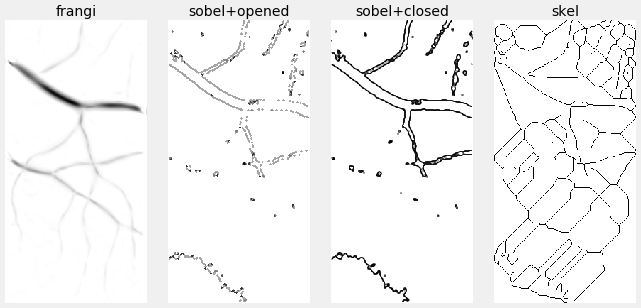

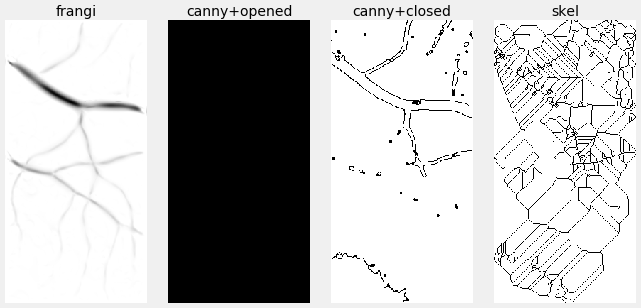

Yen Threshold


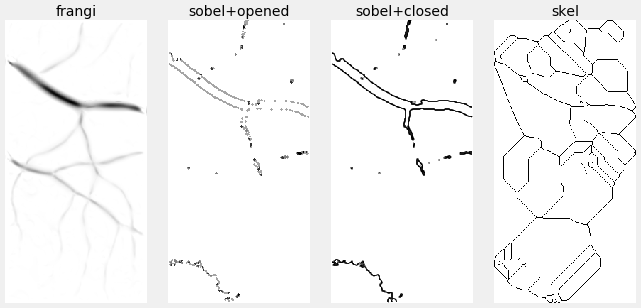

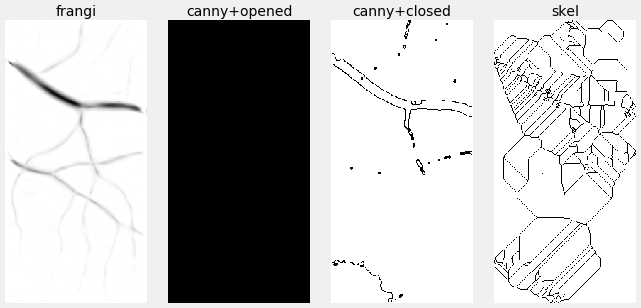

In [9]:
selement = skimage.morphology.disk(1)
print('OTSU Threshold')
morph_with_edge1st_vessel_enhance(img, selement, sigma=1,
                               thresher=skimage.filters.threshold_otsu)
plt.clf();

print('Yen Threshold')
morph_with_edge1st_vessel_enhance(img, selement, sigma=1,
                               thresher=skimage.filters.threshold_yen)

plt.show(); 

## Frangi's vesselness filter Vs Other Ridge Filters

What are they
- **Meijering neurites:**
- **Hybrid Hessian:** 


**Results**
- Meijering and hybrid hessian track noise in background. 
    - Meijering seems to amplify the vessel signal quite well, though
- Frangi has more vesel contrast than sato 


In [10]:
def compare_ridge_filterz(img, filterz, paramz):
    outsiez = []
    titlez = []
    for i, filt in enumerate(filterz):
        outsiez.append( filt[0](img, **paramz)*-1  )
        titlez.append( filt[1] )
    show_image_list( outsiez, titlez=titlez, nc=len(outsiez))
        

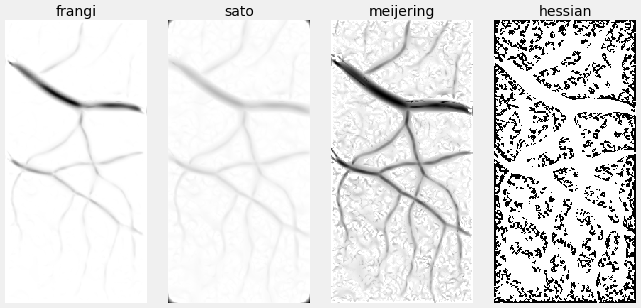

In [11]:
filterz = [
    (skimage.filters.frangi, 'frangi'),
    (skimage.filters.sato, 'sato'),
    (skimage.filters.meijering, 'meijering'),
    (skimage.filters.hessian, 'hessian'),
]

compare_ridge_filterz(img, filterz, paramz)

`meijering` by iself has background noise. 
- Doing a product with either `sato` or `frangi` suppresses noise in all cases
- Doing a product of `frangi` and `meijering` (2nd image) degrades vessel signal so adding back `frangi` output in third image. 
    - Result still loses vessel signal/information compared to `frangi` by itself or `meijering` by itself 
- Doing a product of `sato` and `meijering` (last image) upgrades vessel signal more strongly than the rest

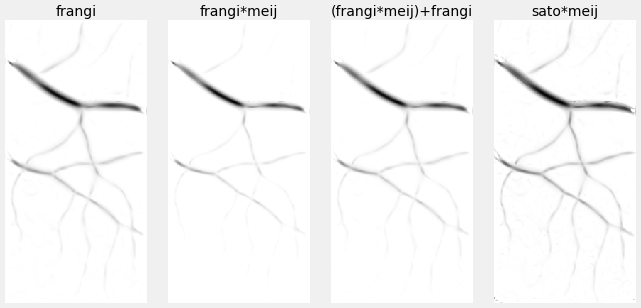

In [12]:
# trying frangi + meijering
img_meij = skimage.filters.meijering(img, **paramz)
show_image_list([ img_frangi2*-1, 
                 (img_frangi2*img_meij)*-1, 
                 ((img_frangi2*img_meij)+img_frangi2)*-1, 
                 img_sato2*img_meij*-1],
                titlez=['frangi','frangi*meij', '(frangi*meij)+frangi', 'sato*meij'], nc=4)


# Frangi's Vs Edge Operators
**Edge Operators:** discrete differential operators that find an approximation of the gradient (1st order derivative) of the image intensities. Some make use of 2nd order derivative such as sobel and canny edge detectors

**What are they** 
- **Sobel:** 
    - 
    
- **Canny:**
    - 
    
- **Scharr:**
    - lesser rotational variance than sobel
    - 
    
    
**Results**
- Without smoothing, there's more noise detected together with the vessels. 
- With smoothing there's still noise when using `sobel` and `scharr` and loss of information when using `canny`. Increasing sigma increases loss of information by `canny` And reducing sigma increases noise amplification by `sobel` and `scharr` 
- 

In [13]:
def apply_edge_operators(img, filterz, sigma=2, ifrangi=img_frangi2):
    ## 1. smooth first to reduce attention to noise 
    ## 2. then apply edge detector 
    def run_it(imgin):
        outsiez = [ifrangi*-1]
        titlez = ['frangi']
        for filt in filterz:
            outsiez.append( filt[1](imgin, **filt[2])*-1 )
            titlez.append( filt[0])
        show_image_list(outsiez, titlez=titlez, nc=len(outsiez) )
    
    print("Before smoothing")
    run_it(img)
    plt.clf();    
    
    print("With smoothing")
    run_it( skimage.filters.gaussian(img, sigma=sigma) )
    plt.show();
    

Before smoothing


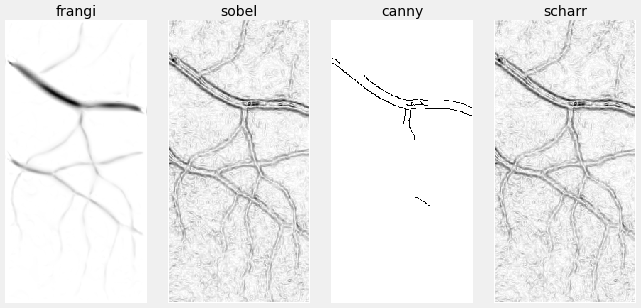

With smoothing


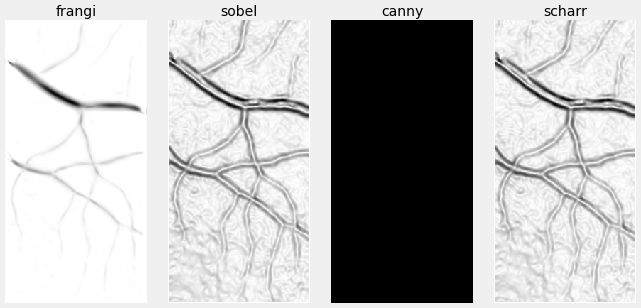

In [14]:
edge_filterz = [
    ('sobel', skimage.filters.sobel, {}),
    ('canny', skimage.feature.canny, {}),
    ('scharr', skimage.filters.scharr, {}),
]

apply_edge_operators(img, edge_filterz, sigma=2)